In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
import itertools
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from typing import *

import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pd.options.display.max_rows = 200
pd.options.display.max_columns = 400

warnings.filterwarnings("ignore")

/root/.cache/pypoetry/virtualenvs/root-qv7zuvpL-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, inputs: int, outputs: int):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, outputs)

    def forward(self, x: torch.Tensor):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
def get_random_state(dim: int) -> torch.Tensor:
    return torch.from_numpy((np.random.rand(dim) > 0.5).astype(np.float32)).view(1, -1)


def get_fixed_reward(action: torch.Tensor) -> float:
    action_idx = action.item()
    if actions[action_idx] == "Down":
        return 1
    else:
        return -1

### Training

In [5]:
dqn_params = {
    "BATCH_SIZE": 128,
    "GAMMA": 0.999,
    "EPS_START": 0.9,
    "EPS_END": 0.05,
    "EPS_DECAY": 200,
    "MEMORY_LENGTH": 10000,
}

TARGET_UPDATE = 10

In [26]:
actions = np.array(["Hold", "Up", "Down"])
n_actions = actions.shape[0]
state_dim = 10

In [110]:
class DQNAgent(object):
    PSEUDO_INF = 1e10
    
    def __init__(self, state_dim: int, n_actions: int, device: torch.device, params: Dict[str, Any]):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = device
        self.params = params
        
        self.policy_net = DQN(inputs=state_dim, outputs=n_actions).to(device)
        self.target_net = DQN(inputs=state_dim, outputs=n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(capacity=self.params["MEMORY_LENGTH"])
        
        self.steps_done = 0
        
        self.state_action_parser = StateActionParser(n_actions=n_actions)
    
    def select_action(self, state: torch.Tensor) -> torch.Tensor:
        sample = random.random()
        eps_threshold = self.params["EPS_END"] + (self.params["EPS_START"] - self.params["EPS_END"]) * math.exp(-1. * self.steps_done / self.params["EPS_DECAY"])
        self.steps_done += 1
        if sample > eps_threshold:
            return self.select_fixed_action(state=state)
        else:
            return self.select_feasible_action(logit=torch.from_numpy(np.random.rand(self.n_actions)).view(1, -1), state=state)
    
    def select_fixed_action(self, state: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return self.select_feasible_action(logit=self.policy_net(state), state=state)
    
    def select_feasible_action(self, logit: torch.Tensor, state: torch.Tensor):
        infeasible_mask = self.state_action_parser.get_infeasible_action_mask(state=state)
        logit += -self.PSEUDO_INF * infeasible_mask
        return logit.max(1)[1].view(1, 1)
    
    def optimize_model(self) -> None:
        if len(self.memory) < self.params["BATCH_SIZE"]:
            return
        transitions = self.memory.sample(self.params["BATCH_SIZE"])
        batch = Transition(*zip(*transitions))
        
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)), 
            device=self.device, 
            dtype=torch.bool
        )
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(self.params["BATCH_SIZE"], device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.params["GAMMA"]) + reward_batch
        
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def store_transition(self, transition: Tuple[torch.Tensor]) -> None:
        self.memory.push(*transition)
        
    def update_model(self) -> None:
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        
class StateActionParser(object):
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
    
    def get_infeasible_action_mask(self, state: torch.Tensor) -> torch.Tensor:
        if state[0][0].item() == 0:
            return torch.tensor([0, 0, 0], dtype=torch.float32)
        else:
            return torch.tensor([1, 0, 0], dtype=torch.float32)

In [111]:
agent = DQNAgent(state_dim=state_dim, n_actions=n_actions, device=device, params=dqn_params)

episode_durations = []
num_episodes = 50
for i_episode in tqdm(range(num_episodes)):
    rewards = list()
    # Initialize the environment and state
    state = get_random_state(state_dim)
    for t in range(100):
        # Select and perform an action
        action = agent.select_action(state)
        reward = get_fixed_reward(action)
        rewards.append(reward)
        reward = torch.tensor([reward], device=device)

        # Observe new state
        next_state = get_random_state(state_dim)

        # Store the transition in memory
        agent.store_transition((state, action, next_state, reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()
    
    episode_durations.append(np.mean(rewards))

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        agent.update_model()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.72it/s]


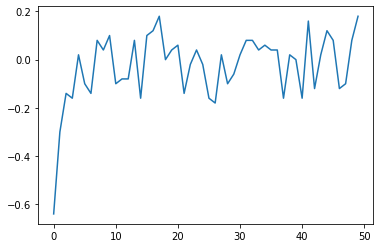

In [109]:
plt.plot(episode_durations)

In [31]:
rewards = list()
for t in range(100):
    # Select and perform an action
    action = agent.select_fixed_action(state)
    reward = get_fixed_reward(action)
    rewards.append(reward)
    reward = torch.tensor([reward], device=device)

    # Observe new state
    next_state = get_random_state(state_dim)

    # Move to the next state
    state = next_state

print(f"Reward(fixed): {np.mean(rewards)}")

Reward(fixed): 1.0
